In [33]:
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
from tensorboard.plugins.beholder import Beholder
import math
import numpy as np

In [34]:
# X_train = pickle.load(open("X_train.pickle", "rb"))
# y_train = pickle.load(open("y_train.pickle", "rb"))
# X_test = pickle.load(open("X_test.pickle", "rb"))
# y_test = pickle.load(open("y_test.pickle", "rb"))


# X_train = X_train.astype('float32')
# y_train = y_train.astype('float32')
# X_test = X_test.astype('float32')
# y_test = y_test.astype('float32')
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [35]:
# one_hot = {0:[1, 0],
#            1:[0, 1]}

In [36]:
one_hot = {0: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
           1: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
           2: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
           3: [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
           4: [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
           5: [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
           6: [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
           7: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
           8: [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
           9: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]}

In [37]:
X_train.shape

(60000, 28, 28)

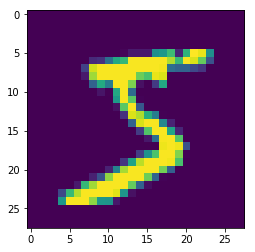

In [38]:
plt.imshow(X_train[0])
plt.show()


In [39]:
y_labels_test = []
y_labels_train = []
for y in y_test:
    y_labels_test.append(one_hot[y])
for y in y_train:
    y_labels_train.append(one_hot[y])

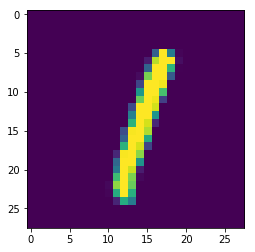

[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]


In [40]:
import matplotlib.pyplot as plt
plt.imshow(X_test[5])

plt.show()
print(y_labels_test[5])

In [41]:
LOGDIR = 'seventh'
BATCH_SIZE = 32
EPOCHS = 500
LR = 0.5e-5
IMG_FLATTEN = 28 * 28
n_classes = 10

In [42]:
def next_batch(num, data, labels):
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

In [44]:
def network(x):
    with tf.name_scope("Reshape"):    
        x_image = tf.reshape(x, [-1, IMG_FLATTEN])
    with tf.name_scope("Magic"):
        Y = tf.matmul(x_image, W) + B
    return Y

tf.reset_default_graph()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
    
with tf.name_scope("inputs"):
    x = tf.placeholder(tf.float32, shape=[None, 28, 28], name="x")
    y = tf.placeholder(tf.float32, shape=[None, 10], name="labels")
    
with tf.name_scope("weight"):
    W = tf.Variable(tf.truncated_normal([IMG_FLATTEN, n_classes], stddev=0.5))
    tf.summary.histogram("weight", W)
with tf.name_scope("bias"):
    B = tf.Variable(tf.truncated_normal([1, n_classes], stddev=0.5))
    tf.summary.histogram("bias", W)

logits = network(x)

with tf.name_scope("xent"):
    xent = tf.reduce_mean(
                    tf.nn.softmax_cross_entropy_with_logits_v2(
                    labels=y, logits=logits), name="xent")
    tf.summary.scalar("xent", xent)
    
with tf.name_scope("train"):
    train_step = tf.train.AdamOptimizer(LR, name='Adam').minimize(xent)

with tf.name_scope("accuracy"):
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    tf.summary.scalar("accuracy", accuracy)

with tf.name_scope("accuracy_val"):
    correct_prediction_val = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
    accuracy_val = tf.reduce_mean(tf.cast(correct_prediction_val, tf.float32))
    tf.summary.scalar("accuracy_val", accuracy_val)

summ = tf.summary.merge_all()

saver = tf.train.Saver()

with tf.Session(config=config) as sess:
        
    beholder = Beholder(LOGDIR)
    
    sess.run(tf.global_variables_initializer())
    writer = tf.summary.FileWriter(LOGDIR)
    writer.add_graph(sess.graph)

    for i in range(EPOCHS):
        print(i)

        [train_accuracy, s] = sess.run([accuracy, summ], feed_dict={x: X_train[0:700], y: y_labels_train[0:700]})
        [test_accuracy, s] = sess.run([accuracy_val, summ], feed_dict={x: X_test[0:700], y: y_labels_test[0:700]})
        writer.add_summary(s, i)

            
        for j in range(math.ceil(len(X_train) / BATCH_SIZE)):
            batch_x, batch_y = next_batch(num = BATCH_SIZE, data = X_train, labels = y_labels_train)
            sess.run(train_step, feed_dict={x: batch_x, y: batch_y})
        beholder.update(session=sess)

    export_path =  './savedmodel7'
    builder = tf.saved_model.builder.SavedModelBuilder(export_path)
    tensor_info_x = tf.saved_model.utils.build_tensor_info(x)
    tensor_info_y = tf.saved_model.utils.build_tensor_info(logits)

    prediction_signature = (
      tf.saved_model.signature_def_utils.build_signature_def(
          inputs={'x_input': tensor_info_x},
          outputs={'y_output': tensor_info_y},
          method_name=tf.saved_model.signature_constants.PREDICT_METHOD_NAME))

    builder.add_meta_graph_and_variables(
      sess, [tf.saved_model.tag_constants.SERVING],
      signature_def_map={
          tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY:
              prediction_signature 
      },
      )
    builder.save()
    sess.close()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
from IPython.display import display_html
def restartkernel() :
    display_html("<script>Jupyter.notebook.kernel.restart()</script>",raw=True)
restartkernel()

In [1]:
# from keras.datasets import mnist
# (X_train, y_train), (X_test, y_test) = mnist.load_data()

In [45]:
import pickle

X_test = pickle.load(open("X_test.pickle", "rb"))
y_test = pickle.load(open("y_test.pickle", "rb"))

X_test = X_test.astype('float32')
y_test = y_test.astype('float32')

FileNotFoundError: [Errno 2] No such file or directory: 'X_test.pickle'

In [46]:
import tensorflow as tf
with tf.Session() as sess:
    signature_key = tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY
    input_key = 'x_input'
    output_key = 'y_output'

    export_path =  './savedmodel7'
    meta_graph_def = tf.saved_model.loader.load(
               sess,
              [tf.saved_model.tag_constants.SERVING],
              export_path)
    signature = meta_graph_def.signature_def

    x_tensor_name = signature[signature_key].inputs[input_key].name
    y_tensor_name = signature[signature_key].outputs[output_key].name

    x = sess.graph.get_tensor_by_name(x_tensor_name)
    y = sess.graph.get_tensor_by_name(y_tensor_name)

    y_out = sess.run(y, {x: X_test})
    vars = tf.trainable_variables()
    print(vars) #some infos about variables...
    vars_vals = sess.run(vars)
    vizs = []
    for var, val in zip(vars, vars_vals):
        print("var: {}, value: {}".format(var.name, val))
        vizs.append(val)

INFO:tensorflow:Restoring parameters from ./savedmodel7\variables\variables
[<tf.Variable 'weight/Variable:0' shape=(784, 10) dtype=float32_ref>, <tf.Variable 'bias/Variable:0' shape=(1, 10) dtype=float32_ref>, <tf.Variable 'weight/Variable:0' shape=(784, 10) dtype=float32_ref>, <tf.Variable 'bias/Variable:0' shape=(1, 10) dtype=float32_ref>]
var: weight/Variable:0, value: [[-0.25093302 -0.47738242  0.56828284 ... -0.20545973 -0.43007937
   0.3229533 ]
 [-0.16522466  0.6059255  -0.31128377 ...  0.18776073 -0.14435905
   0.37531468]
 [-0.32942304 -0.4866678   0.26607245 ... -0.2526814   0.39577976
   0.15221159]
 ...
 [ 0.26774532  0.29788002  0.36630243 ... -0.40439034 -0.2198804
  -0.0155788 ]
 [-0.83152753 -0.6041829  -0.9454912  ...  0.33808383  0.03887105
   0.26044422]
 [ 0.26298198 -0.5268328   0.78114325 ... -0.7477729  -0.04552973
   0.4520053 ]]
var: bias/Variable:0, value: [[-0.29100752 -0.09304487  0.37837616  0.1681483  -0.40742123  0.87560976
  -0.6190015   0.8107308  -0.2

In [75]:
vizs[0]

array([[-0.25093302, -0.47738242,  0.56828284, ..., -0.20545973,
        -0.43007937,  0.3229533 ],
       [-0.16522466,  0.6059255 , -0.31128377, ...,  0.18776073,
        -0.14435905,  0.37531468],
       [-0.32942304, -0.4866678 ,  0.26607245, ..., -0.2526814 ,
         0.39577976,  0.15221159],
       ...,
       [ 0.26774532,  0.29788002,  0.36630243, ..., -0.40439034,
        -0.2198804 , -0.0155788 ],
       [-0.83152753, -0.6041829 , -0.9454912 , ...,  0.33808383,
         0.03887105,  0.26044422],
       [ 0.26298198, -0.5268328 ,  0.78114325, ..., -0.7477729 ,
        -0.04552973,  0.4520053 ]], dtype=float32)

In [83]:
vizs[0][783][9]

0.4520053

## Weights for all the outputs

0


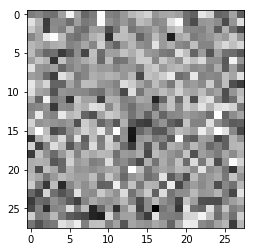

1


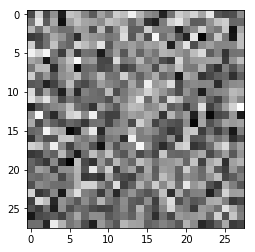

2


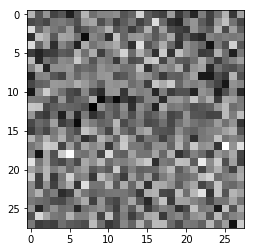

3


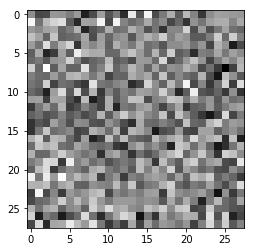

4


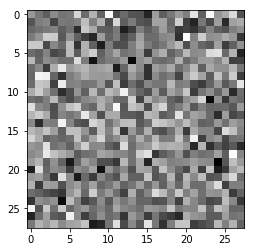

5


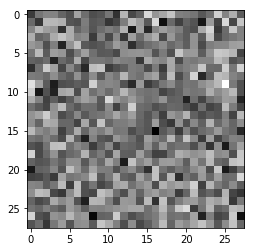

6


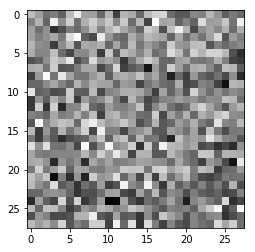

7


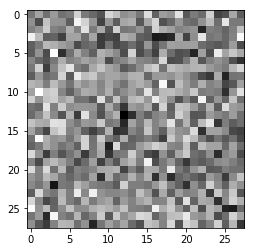

8


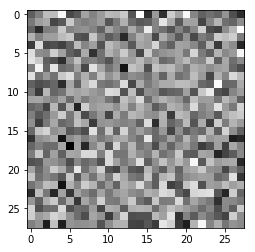

9


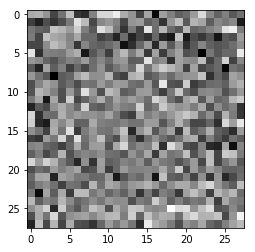

In [87]:
import numpy as np
for j in range(10):
    z = []
    for i in range(784):
        z.append(vizs[0][i][j])
    z = np.array(z)
    bb = np.reshape(z, (28, 28))
    import matplotlib.pyplot as plt
    plt.imshow(bb, cmap = "gray")
    print(j)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


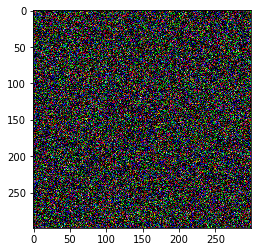

In [22]:
import numpy as np
z = []
for i in range(len(aaa[0])):
    z.append(vizs[0][i][1])
z = np.array(z)
bb = np.reshape(z, (299, 299, 3))
import matplotlib.pyplot as plt
plt.imshow(bb)

In [48]:
import numpy as np
predicted_values = []
for i in range(len(y_out)):
    index_max = np.argmax(y_out[i])
    predicted_values.append(index_max)

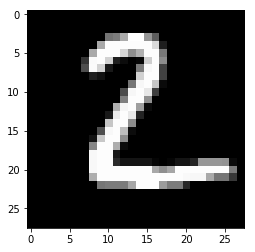

In [49]:
import matplotlib.pyplot as plt
import numpy as np
def imshow(img):
 # unnormalize
    #npimg = img.numpy()
    plt.imshow(np.transpose(img[0], (1, 2, 0)))
    plt.show()
plt.imshow(X_test[1], cmap="gray")
plt.show()

In [52]:
def classification_metrics(actual, pred, msg):
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(actual, pred)
    import seaborn as sns     

    plt.figure()
    ax= plt.subplot()
    sns.heatmap(cm, annot = True, fmt = 'g')

    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels') 
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']) 
    ax.yaxis.set_ticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])   
    plt.show()       
    sensitivity = cm[1][1]/(cm[1][0] + cm[1][1])
    specifity = cm[0][0]/(cm[0][0] + cm[0][1])
    accuracy = (cm[0][0] + cm[1][1]) / np.sum(cm)
    
#     print(msg, '\n')
#     print('accuracy:    ', round(accuracy,2), 
#       '\nsensitivity: ', round(sensitivity,2), 
#       '\nspecifity:   ', round(specifity,2))
    from sklearn.metrics import classification_report
    print(classification_report(actual, pred))
              


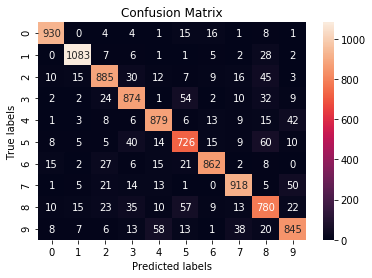

              precision    recall  f1-score   support

           0       0.94      0.95      0.95       980
           1       0.95      0.95      0.95      1135
           2       0.88      0.86      0.87      1032
           3       0.85      0.87      0.86      1010
           4       0.88      0.90      0.89       982
           5       0.81      0.81      0.81       892
           6       0.92      0.90      0.91       958
           7       0.90      0.89      0.90      1028
           8       0.78      0.80      0.79       974
           9       0.86      0.84      0.85      1009

   micro avg       0.88      0.88      0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [53]:
classification_metrics((y_test).astype(int), predicted_values, msg = '')